## Installing and mounting

### Installing

In [ ]:
# downloading and installing the open_clip model
# this only has to be done the very first time (therefore commented)
!pip install open_clip_torch

### Mounting

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to the image file
folder_path = '/content/drive/MyDrive/CSE493G1 Project/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pickle
import os
import time

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import open_clip

## Functions

### Helper functions

In [ ]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

def get_model():
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    if torch.cuda.is_available():
        model.cuda()
    else:
        model.float()
    return model, preprocess

def get_logits(image_features, text_features, logit_scale):
    logits_per_image = logit_scale * image_features @ text_features.T
    logits_per_text = logit_scale * text_features @ image_features.T
    return logits_per_image, logits_per_text

def get_ground_truth_images(images, texts, captions):
    expanded_texts = texts.unsqueeze(1).expand(-1, len(captions), -1)
    equal_mask = torch.all(torch.eq(expanded_texts, captions), dim=2)
    ground_truth_images = equal_mask.nonzero(as_tuple=True)[1]
    return ground_truth_images

def get_ground_truth_texts(images, texts, captions):
    ground_truth_text_2 = torch.zeros(len(captions), len(texts), dtype=torch.float32, device=device)

    expanded_texts = texts.unsqueeze(1).expand(-1, len(captions), -1)
    equal_mask = torch.all(torch.eq(expanded_texts, captions), dim=2)
    num_matching = torch.sum(equal_mask, dim=0)

    ground_truth_text_2 = torch.where(equal_mask.T, 1 / num_matching.unsqueeze(1), ground_truth_text_2)
    return ground_truth_text_2

### Training function

In [ ]:
def train(num_epochs, model, train_dataloader, optimizer, loss_fn, captions, device, val=False, val_dataloader=None):
    if val and val_dataloader==None:
        raise Exception("val_dataloader is needed for validation")
    total_images = 0
    total_loss = 0
    for epoch in range(num_epochs):
        model.train()
        pbar = tqdm(train_dataloader, total=len(train_dataloader))
        for batch in pbar:
            optimizer.zero_grad()
            images,texts = batch
            total_images += images.size()[0]
            images= images.to(device)
            texts = texts.to(device)

            # Forward pass
            image_features, text_features, logit_scale = model(images, captions)
            logits_per_image, logits_per_text = get_logits(image_features, text_features, logit_scale)

            # Calculate ground truth
            ground_truth_images = get_ground_truth_images(images, texts, captions)
            ground_truth_texts = get_ground_truth_texts(images, texts, captions)

            # Compute loss
            loss = (loss_fn(logits_per_image, ground_truth_images) + loss_fn(logits_per_text, ground_truth_texts)) / 2
            loss.backward()
            total_loss += loss.item()

            # Backward pass
            optimizer.step()

            pbar.set_description(f"Training: Epoch {epoch}/{num_epochs}, Loss: {total_loss / total_images:.4f}")
    if val:
        val(model, val_dataloader, loss, device)


### Testing function

In [ ]:
def test(model, test_dataloader, device):
    total_images = 0
    total_correct = 0
    model.eval()
    pbar = tqdm(test_dataloader, total=len(test_dataloader))
    for batch in pbar:
        images,texts = batch
        total_images += images.size()[0]
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        with torch.no_grad():
            image_features, text_features, logit_scale = model(images, captions)
        logits_per_image, logits_per_text = get_logits(image_features, text_features, logit_scale)

        # Calculate ground truth
        ground_truth_images = get_ground_truth_images(images, texts, captions)

        # Compute similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Count correct ones
        num_correct = torch.sum(torch.argmax(text_probs, dim=-1) == ground_truth_images)
        total_correct += num_correct

        pbar.set_description(f"Testing: Accuracy: {total_correct / total_images}")

### Validation function

In [ ]:
def val(model, val_dataloader, captions, loss_fn, device):
    total_images = 0
    total_correct = 0
    total_loss = 0
    model.eval()
    pbar = tqdm(val_dataloader, total=len(val_dataloader))
    for batch in pbar:
        images,texts = batch
        total_images += images.size()[0]
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        with torch.no_grad():
            image_features, text_features, logit_scale = model(images, captions)
        logits_per_image, logits_per_text = get_logits(image_features, text_features, logit_scale)

        # Calculate ground truth
        ground_truth_images = get_ground_truth_images(images, texts, captions)
        ground_truth_texts = get_ground_truth_texts(images, texts, captions)

        # Compute loss
        loss = (loss_fn(logits_per_image, ground_truth_images) + loss_fn(logits_per_text, ground_truth_texts)) / 2
        total_loss += loss.item()

        # Compute similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Count correct ones
        num_correct = torch.sum(torch.argmax(text_probs, dim=-1) == ground_truth_images)
        total_correct += num_correct

        pbar.set_description(f"Validation: Accuracy: {total_correct / total_images}, Loss: {total_loss / total_images:.4f}")
    return total_correct / total_images, total_loss / total_images

### Loading the data

In [ ]:
# Define a custom dataset
class image_title_dataset():
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = tokenizer(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

def get_dataset(label_pre, label_post, labels):
    list_image_path_train = []
    list_txt_train = []
    crop_classes = ["arugula", "basil", "red kale", "lettuce"]
    directory = '/content/drive/MyDrive/CSE493G1 Project/Data/Preprocessed Data/'
    for i, crop_class in enumerate(crop_classes):
      for filename in os.listdir(directory + crop_class):
          f = os.path.join(directory + crop_class, filename)
          # checking if it is a file
          if os.path.isfile(f):
            file_name, file_extension = os.path.splitext(f)
            if file_extension == ".jpg":
              list_image_path_train.append(f)
              caption = label_pre + labels[i] + label_post
              list_txt_train.append(caption)
    return image_title_dataset(list_image_path_train, list_txt_train)


class_names = ["arugula", "basil", "red kale", "lettuce"]
v = "an image of a "
n = " plant"

dataset_train = get_dataset(v, n, class_names)
train_dataloader = DataLoader(dataset_train, batch_size=10, shuffle=True)

## Training / Evaluation

### Evaluate different captions

In [ ]:
model, preprocess = get_model() # always gets a new model, if you don't want to lose the model after training, put this line into another code block
loss_fn = nn.CrossEntropyLoss() # for training have to include a weight because not all classes are equaly represented
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-7,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

class_labels = [["arugula", "basil", "red kale", "lettuce"], ["hydroponic arugula", "hydroponic basil", "hydroponic red kale", "hydroponics lettuce"], ["arugula", "italian basil", "red russian kale", "buttercrunch lettuce"]]
labels_pre = ["an image of a ", "this is an image of a ", "a picture of a ", "a ", "this is a ", "a photo of a ", ""]
labels_post = ["", " plant", " hydroponic plant"]
cache = []

for class_label in class_labels:
    class_dic = {}
    for label_post in labels_post:
        class_dic[label_post] = []
    for label_pre in labels_pre:
        for label_post in labels_post:
            dataset_val = get_dataset(label_pre, label_post, class_label)
            val_dataloader = DataLoader(dataset_val, batch_size=50, shuffle=True)
            captions = tokenizer([label_pre + crop_class + label_post for crop_class in class_label]).to(device)
            print([label_pre + crop_class + label_post for crop_class in class_label])
            accuracy, loss = val(model, val_dataloader, captions, loss_fn, device)
            class_dic[label_post].append(torch.round(accuracy.cpu(), decimals=3, out=None))
    cache.append(class_dic)

timestamp = time.time()
with open(folder_path + f'cache_{timestamp}.pkl', 'wb') as f:
    pickle.dump(cache, f)

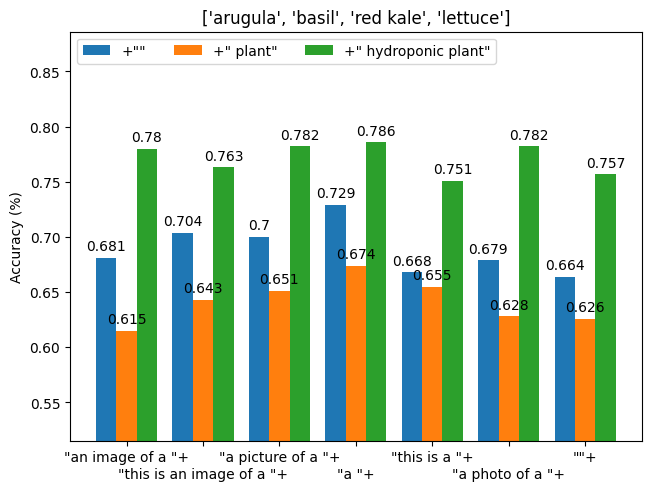

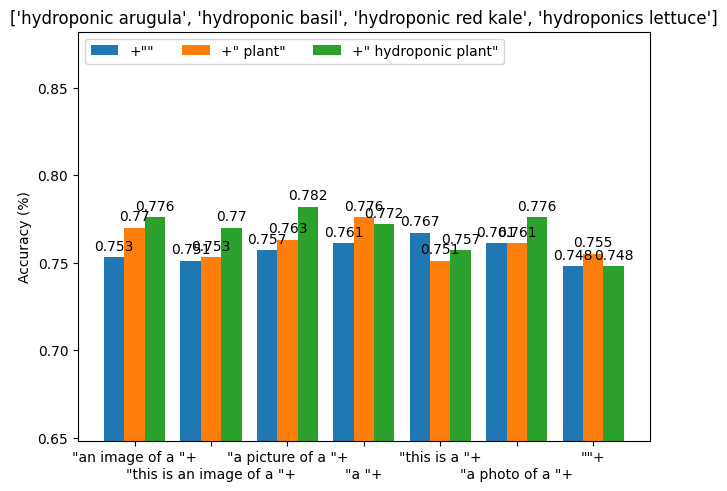

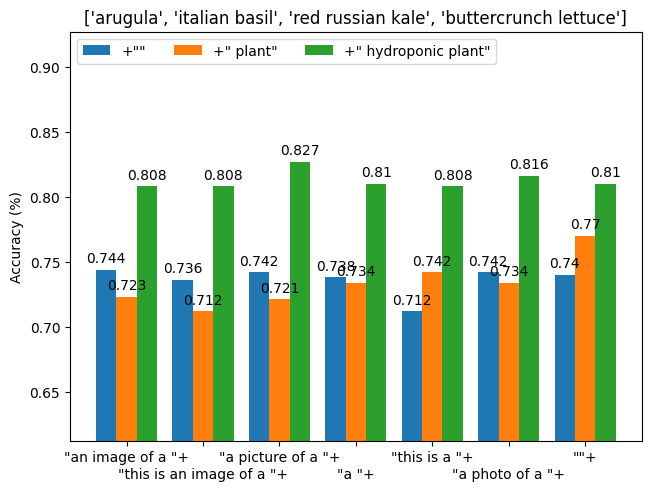

In [ ]:
with open(folder_path + f'cache_{timestamp}.pkl', 'rb') as f:
    cache = pickle.load(f)

class_labels = [["arugula", "basil", "red kale", "lettuce"], ["hydroponic arugula", "hydroponic basil", "hydroponic red kale", "hydroponics lettuce"], ["arugula", "italian basil", "red russian kale", "buttercrunch lettuce"]]


for i, classes in enumerate(cache):
    labels_pre = ["\"an image of a \"+", "\n\"this is an image of a \"+", "\"a picture of a \"+", "\n\"a \"+", "\"this is a \"+", "\n\"a photo of a \"+", "\"\"+"]

    x = np.arange(len(labels_pre))
    width = 0.4
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    min_bar = 1
    max_bar = 0
    for attribute, measurement in classes.items():
        offset = width * multiplier
        rects = ax.bar(x*1.5 + offset, measurement, width, label=("+\""+attribute+"\""))
        ax.bar_label(rects, padding=3)
        multiplier += 1
        min_bar = min(min(measurement), min_bar)
        max_bar = max(max(measurement), max_bar)

    ax.set_ylabel('Accuracy (%)')
    ax.set_title(class_labels[i])
    ax.set_xticks(x*1.5 + width, labels_pre)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(min_bar - 0.1, max_bar + 0.1)

    plt.show()
    print()